# Model Interpretability and Independent validation using model with transfer learning over independent validation dataset

In this notebook we are exploring the results of the clinical transformer to identify the important features (functional groups, feature permutation importance) as well as the impact on survival (Kapplan-Meier curves on the predicted populations). 

In [28]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append('../codeocean/environment/clinical_transformer/')

In [29]:
from xai.models.explainer import TransformerSurvivalEvaluator
from xai.models.explainer import survival_attention_scores
from xai.models import load_transformer

In [30]:
import pandas as pd
from samecode.random import set_seed
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
from samecode.survival.plot import KMPlot
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index as lfcindex
import seaborn as sns
from shap.plots import colors
from glob import glob
import os
colors = [colors.blue_rgb, colors.red_rgb]

## Dataset

In [31]:
train_data = pd.read_csv('./data/dataset-train.data.csv')
train_data['sample_id'] = train_data.index

test_data = pd.read_csv('./data/dataset-test.data.csv')
test_data = test_data[~test_data.TMB.isna()].reset_index(drop=True)

test_data['sample_id'] = test_data.index

    
features = train_data.columns[-44:].tolist()

In [32]:
path = './results/runs/TransferLearningSurvival/model.E001000.h5/'
#path = './results/runs/Survival/'
run = 'fold-0_id-0'
sample_id = 'sample_id'
epoch = 200

In [33]:
res = pd.Series(glob(os.path.join(path,'*/model.*.h5')))
pp = res.apply(lambda x:x.replace(path, ''))
fd = pp.apply(lambda x:x.split('/')[0])
eps = pp.apply(lambda x:x.split('/')[1]).apply(lambda x:x.split('.')[1]).apply(lambda x:x.replace('E', '')).astype(int)

In [34]:
dfres = pd.concat([res,fd,eps], axis=1)
#dfres = dfres.set_index(0)

In [35]:
best_model_paths = dfres.groupby(1).apply(lambda x:x[2].max())

In [36]:
train_beta  = []
test_beta = []
train_c = []
test_c = []

for run, epoch in best_model_paths.items():
    trainer = load_transformer(path, run, epoch=epoch)
    transformed_data = trainer.data_converter.transform(train_data).reset_index(drop=True)

    set_seed(0)

    evaluator = TransformerSurvivalEvaluator(model=trainer)

    train_data, outputs, features, patient_ids, iters, attention_scores = survival_attention_scores(
        transformed_data, evaluator, iterations=1, sample_id=sample_id
    )
    
    train_cindex = lfcindex(train_data['time'], train_data['β'], train_data['event'])

    transformed_test_data = trainer.data_converter.transform(test_data).reset_index(drop=True)


    evaluator = TransformerSurvivalEvaluator(model=trainer)

    test_data, outputs, features, patient_ids, iters, attention_scores = survival_attention_scores(
        transformed_test_data, evaluator, iterations=10, sample_id=sample_id
    )

    test_cindex = lfcindex(test_data['time'], test_data['β'], test_data['event'])
    
    test_c.append(test_cindex)
    train_c.append(train_cindex)
    test_beta.append(test_data['β'])     
    train_beta.append(train_data['β'])

100%|█████████████████████████████████████████████████████████████████████████████████| 234/234 [00:06<00:00, 33.85it/s]


In [37]:
df_cindex = pd.DataFrame([test_c, train_c]).T
df_cindex.columns = ['test_cindex', 'train_cindex']

train_β = pd.concat(train_beta, axis=1).mean(axis=1)
test_β = pd.concat(test_beta, axis=1).mean(axis=1)

test_data['β'] = test_β
train_data['β'] = train_β
median_cutoff = np.quantile(train_data.β, 0.5)

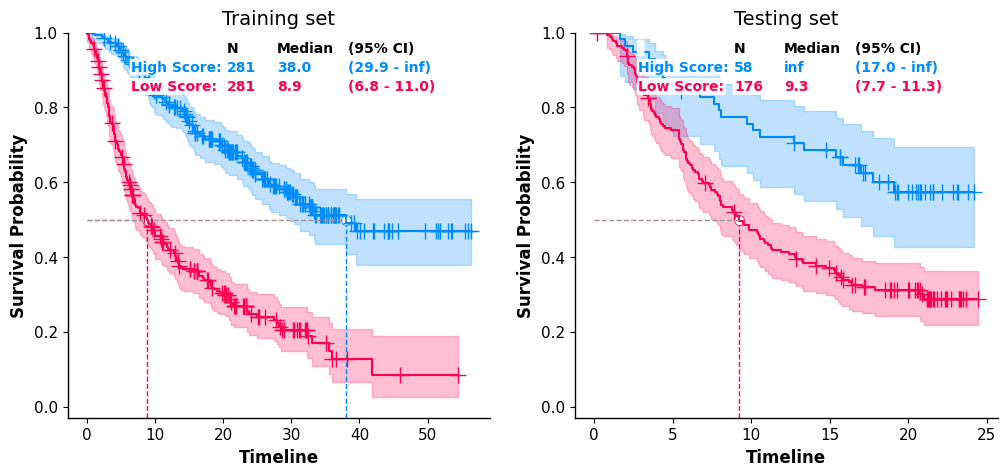

In [38]:
test_data['population'] = (test_data.β >= median_cutoff).replace([False, True], ['Low Score', 'High Score'])
train_data['population'] = (train_data.β >= median_cutoff).replace([False, True], ['Low Score', 'High Score'])

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (12,5))
KMPlot(train_data, time='time', event='event', label=['population']).plot(ax=axs[0], 
                                                                          colors = colors, 
                                                                          title='Training set',
                                                                          ci_show=True,ci_alpha=0.10,
                                                                         )
KMPlot(test_data, time='time', event='event', label=['population']).plot(ax=axs[1],
                                                                         colors = colors, ci_show=True,
                                                                         ci_alpha=0.10,
                                                                         title='Testing set')

In [40]:
df_cindex.mean()

test_cindex     0.588191
train_cindex    0.704164
dtype: float64

In [41]:
df_cindex.std()

test_cindex     0.011107
train_cindex    0.015801
dtype: float64